In [1]:
import pandas as pd

In [2]:

df = pd.read_csv('our-bma.csv')


In [3]:
df


,Refs,Reads
0,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,ACTATAATGCGTGGGACCGACCTCGGAATGCGGTCTCCATGCGCGT...
1,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...,TCAAAGCAGTTAGGGCCTACCAAATAGGTGGTCCTCCTTGTATCTA...
2,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...,ATTTAACGTCCCACGGTAGGCACTCTTGATCCCCACTTCAAGAGGT...
3,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...,GCCCAAGGGAAGCCCGCAGCGACCGTAATTGGCGGAATAAGCGCGT...
4,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...,GCAATGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...
...,...,...
9995,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...,GTATGTTTGGAAAGTGGCAGGATTACACACCACCCAGGGTATATGG...
9996,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGTTGCCTTCTAGTAT...
9997,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...
9998,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGTCTTCGA...,ACTGGACGTCCTATGGTGCCAATAATGAAACGACAACCTTTCTTAT...


In [4]:
from tqdm import tqdm


In [5]:
noisy_strands = [s.strip() for s in list(df['Reads'])]


In [6]:
ref_strands = [s.strip() for s in list(df['Refs'])]


In [7]:
import difflib


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os

# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021basic/bin/universal-darwin'

In [9]:
def print_diff(ref_strand, noisy_strand):
    global pairs
    global pairs_no_pos
    a, b = 0, 0

    # quadratic time, no heuristics
    for match in difflib.SequenceMatcher(None, ref_strand, noisy_strand, autojunk=False).get_matching_blocks():
        was = ref_strand[a:match.a]
        now = noisy_strand[b:match.b]
        
        a = match.a + match.size
        b = match.b + match.size
        
        if was == '' and now == '':
            pass
        else:
            # print('{}|{}'.format(was, now), end=', ')
            pairs += [(was, now, match.a)]
            pairs_no_pos += [(was, now)]



100%|██████████| 10000/10000 [00:00<00:00, 69738.97it/s]


[380, 1040, 1633, 2071, 2383, 2789, 3046, 3341, 3542, 3669, 3918, 4023, 4182, 4270, 4352, 4529, 4598, 4640, 4736, 4827, 4841, 4919, 4938, 4898, 4965, 5020, 5183, 5053, 5145, 5214, 5177, 5281, 5278, 5310, 5368, 5343, 5294, 5398, 5340, 5479, 5454, 5486, 5397, 5538, 5458, 5498, 5549, 5481, 5468, 5528, 5505, 5481, 5478, 5526, 5396, 5350, 5369, 5330, 5404, 5332, 5391, 5366, 5325, 5329, 5309, 5333, 5330, 5321, 5355, 5313, 5383, 5294, 5283, 5266, 5285, 5203, 5163, 5207, 5147, 5190, 5054, 4984, 4994, 4962, 4912, 4868, 4718, 4731, 4689, 4621, 4533, 4486, 4396, 4362, 4209, 4168, 4001, 3878, 3765, 3603, 3370, 3270, 2964, 2725, 2441, 2083, 1672, 1223, 570, 121]


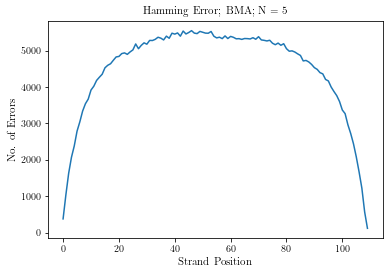

In [10]:
# Hamming Distance Graph
strand_len = 110
count_pos = [0] * (strand_len + 1)

def hamming(ref_strand, recons_strand):
    for i, (c1, c2) in enumerate(zip(ref_strand, recons_strand)):
        if c1 != c2:
            count_pos[i] += 1

for i in tqdm(range(len(ref_strands))):
    hamming(ref_strands[i], noisy_strands[i])

print(count_pos[:-1])
f = plt.figure()
plt.plot(range(strand_len), count_pos[:-1])
plt.title(r'Hamming Error; BMA; N = 6', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov6-sab-bma-hamming.pdf', bbox_inches='tight')

In [11]:
pairs = []
pairs_no_pos = []

for i in tqdm(range(len(ref_strands))):
    if ref_strands[i] != noisy_strands[i]:
        print_diff(ref_strands[i], noisy_strands[i])


100%|██████████| 10000/10000 [00:12<00:00, 826.11it/s]


In [12]:

subs_no_pos, counts_no_pos = np.unique(pairs_no_pos, return_counts=True, axis=0)
sorting = np.argsort(counts_no_pos)
subs_no_pos = subs_no_pos[sorting]
counts_no_pos = counts_no_pos[sorting]

for sub, count in zip(subs_no_pos, counts_no_pos):
    if count > 5:
        print("{} -> {}".format(sub[0], sub[1]), count)


 -> AGTA 6
GGC -> A 6
GTAA ->  6
 -> TGAA 6
 -> ATAC 6
CGGC ->  6
GTGA ->  6
TATC ->  6
 -> AATC 6
ACGT ->  6
GTAC ->  6
 -> GAAT 6
CCA -> T 6
G -> CCTT 6
CC -> TA 6
 -> GCAT 6
AA -> G 6
GCC -> A 6
GTC -> A 6
GCCA ->  6
AGGC ->  6
 -> ATAA 6
AGCC ->  6
CGCC ->  6
 -> TTAG 6
TGGA ->  6
CGAA ->  6
TT -> A 6
AGCG ->  6
 -> AAGT 6
 -> AATAA 6
 -> CATA 6
 -> TCCC 6
GCG -> T 6
 -> GTAG 6
TGAG ->  6
CTAG ->  6
C -> AAG 6
ACGA ->  6
 -> CAAT 6
 -> ACCC 6
 -> TATG 6
GCGT ->  6
AAG -> T 6
GGGC ->  6
 -> TGTT 6
A -> GTTT 6
 -> TCTA 6
C -> AGA 6
 -> AAAAA 6
GTTG ->  6
GTTC ->  6
TCGC ->  6
 -> CAAG 6
 -> ACAT 6
G -> TTTTT 6
 -> ATGT 6
CT -> AA 6
 -> TAGG 6
CGTG ->  6
CCTG ->  6
C -> AAAA 6
 -> TTTAA 6
GC -> AAT 6
T -> CAC 6
 -> CAAC 6
GC -> TTA 6
ATGA ->  6
GGCC ->  6
CGCA ->  7
ACA -> T 7
 -> AGAC 7
AT -> G 7
TACG ->  7
GCA -> T 7
 -> GTTA 7
 -> GCCA 7
GTCA ->  7
TGCA ->  7
 -> CACT 7
 -> CCAA 7
 -> TTGG 7
TGGC ->  7
 -> GGTT 7
AC -> TG 7
TGAC ->  7
CGGA ->  7
 -> TTGC 7
CAGG ->  7
AGCT ->  7
C -

 -> TC @ 23 6
T ->  @ 59 6
T ->  @ 60 6
 -> TT @ 106 6
 -> GA @ 51 6
T -> G @ 83 6
 -> AA @ 7 6
T -> G @ 84 6
 -> A @ 58 6
T -> G @ 87 6
 -> TT @ 1 6
T -> G @ 75 6
T -> G @ 89 6
T -> G @ 90 6
T -> G @ 92 6
T -> A @ 103 6
 -> AT @ 94 6
 -> GG @ 56 6
 -> AT @ 98 6
 -> TC @ 97 6
 -> ATC @ 52 6
 -> AT @ 19 6
 -> AA @ 85 6
T -> G @ 45 6
 -> AT @ 91 6
 -> AA @ 65 6
 -> AGC @ 53 6
T -> C @ 91 6
 -> AGC @ 55 6
 -> AA @ 2 6
 -> TCT @ 54 6
 -> GCT @ 55 6
T -> G @ 40 6
T -> G @ 33 6
T -> G @ 29 6
T -> G @ 27 6
 -> AT @ 7 6
T -> G @ 12 6
T -> G @ 77 6
 -> AA @ 17 6
 -> TA @ 50 6
 -> AA @ 45 6
T -> G @ 102 6
 -> AT @ 79 6
 -> AA @ 50 6
 -> TTT @ 53 6
 -> TTT @ 52 6
 -> TA @ 98 6
 -> TG @ 6 6
T -> G @ 80 6
 -> TA @ 88 6
 -> AG @ 3 6
T -> G @ 108 6
T -> A @ 42 6
T -> C @ 13 6
 -> AA @ 96 6
T -> C @ 83 6
 -> CCC @ 54 6
 -> TT @ 99 6
 -> TT @ 97 6
T -> C @ 5 6
 -> TT @ 92 6
 -> TT @ 91 6
 -> TT @ 87 6
 -> TT @ 86 6
TG ->  @ 100 6
 -> TT @ 8 6
 -> G @ 71 6
 -> TT @ 75 6
 -> TT @ 72 6
TG ->  @ 56 6
TG ->

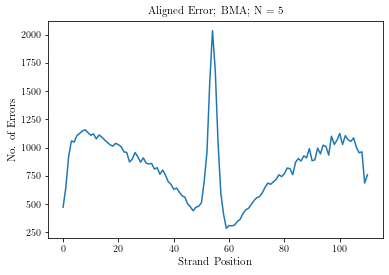

In [13]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]

for sub, count in zip(subs, counts):
    if count > 5:
        print("{} -> {} @ {}".format(sub[0], sub[1], sub[2]), count)

strand_len = 110
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    pos_counts[int(sub[2])] += count

print(pos_counts)

f = plt.figure()
plt.plot(range(strand_len + 1), pos_counts)
plt.title(r'Aligned Error; BMA; N = 6', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov6-sab-bma-aligned.pdf', bbox_inches='tight')

In [14]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]


In [15]:
def get_key(char1, char2):
    char1 = char1 if char1 != '' else '_'
    char2 = char2 if char2 != '' else '_'
    return char1 + ' -> ' + char2

strand_len = 110
pos_map = {}
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    key = get_key(sub[0], sub[1])
    if key not in pos_map:
        pos_map[key] = [0] * (strand_len + 1)
    pos_map[key][int(sub[2])] += count

In [16]:
sub_keys = [get_key(sub[0], sub[1]) for sub in subs_no_pos]
max_10_keys = sub_keys[-10:]
max_10_counts = counts_no_pos[-10:]


[0, 80, 93, 122, 110, 124, 114, 105, 88, 116, 107, 136, 97, 109, 99, 98, 118, 106, 88, 88, 105, 108, 96, 95, 83, 87, 101, 87, 90, 79, 82, 77, 75, 69, 69, 80, 74, 71, 65, 52, 62, 51, 61, 49, 47, 40, 39, 43, 34, 29, 44, 31, 40, 50, 99, 101, 40, 28, 20, 20, 20, 21, 29, 38, 37, 36, 42, 43, 60, 54, 45, 66, 57, 58, 52, 53, 68, 71, 75, 70, 82, 65, 66, 73, 88, 93, 87, 86, 87, 79, 89, 87, 89, 87, 87, 107, 98, 119, 104, 107, 118, 100, 100, 97, 99, 104, 98, 86, 103, 100, 95]
[0, 69, 81, 88, 78, 97, 106, 98, 90, 82, 81, 75, 93, 88, 83, 89, 82, 76, 82, 94, 80, 89, 61, 60, 55, 75, 63, 70, 57, 78, 66, 80, 72, 54, 69, 47, 54, 68, 54, 52, 46, 56, 36, 31, 29, 36, 30, 32, 36, 34, 21, 18, 32, 59, 79, 71, 44, 20, 9, 11, 16, 19, 20, 16, 32, 31, 35, 39, 36, 34, 43, 47, 69, 44, 54, 45, 52, 55, 63, 49, 59, 62, 83, 49, 57, 68, 74, 81, 67, 87, 71, 73, 88, 80, 85, 93, 76, 86, 86, 92, 79, 101, 90, 80, 88, 79, 84, 103, 105, 94, 100]
[134, 76, 101, 91, 86, 90, 94, 95, 90, 93, 82, 70, 69, 75, 78, 68, 67, 59, 64, 62, 

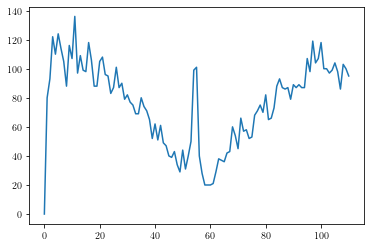

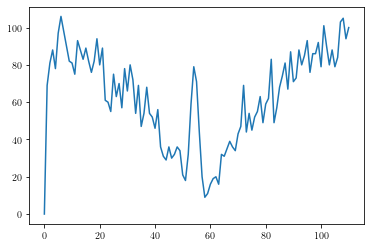

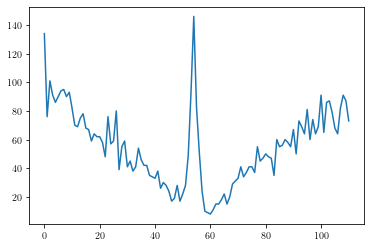

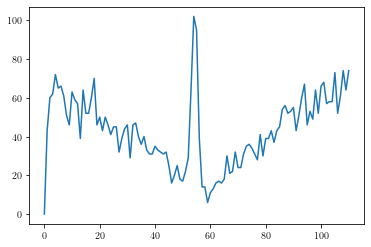

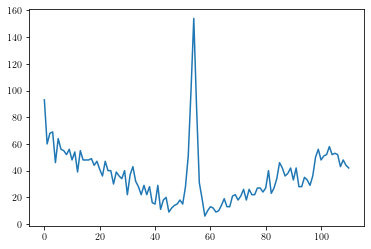

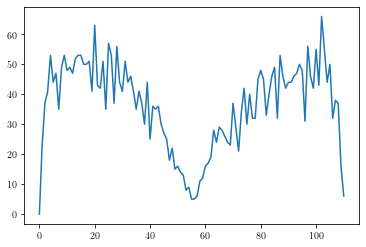

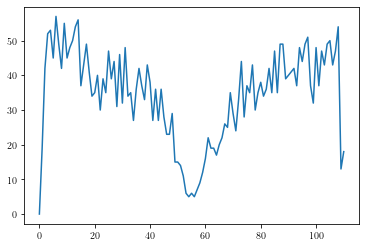

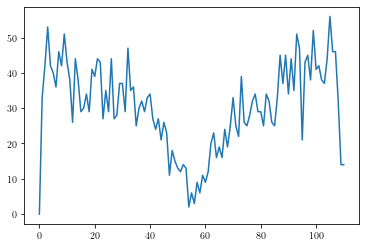

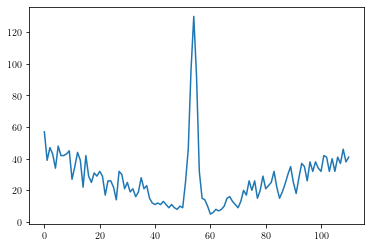

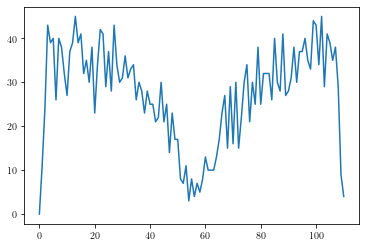

In [17]:
for key, count in zip(reversed(max_10_keys), reversed(max_10_counts)):
    plt.figure(key)
    print(pos_map[key])
    plt.plot(range(strand_len + 1), pos_map[key])

In [18]:
np.save('subs.npy', subs)
np.save('counts.npy', counts)